<a href="https://colab.research.google.com/github/arjun11verma/MLProject2021/blob/main/PneumoniaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:27<00:00, 46.4MB/s]
100% 2.29G/2.29G [00:27<00:00, 90.8MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
import pandas as pd
import numpy as np

import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image

from torchvision import transforms, utils

import torch

from torch.utils.data import Dataset, DataLoader

class XRayDataset(Dataset):

  def __init__(self, folder_dir, transform=None):
    self.folder_dir = folder_dir
    self.transform = transform
    self.num_normal = len(os.listdir(folder_dir + "/NORMAL"))
    self.num_pneumonia = len(os.listdir(folder_dir + "/PNEUMONIA"))
    self.length = self.num_normal + self.num_pneumonia

    #self.NORMAL = 

  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    path = ""
    label = 0 # normal
    if idx < self.num_normal:
      dir = self.folder_dir + "/NORMAL"
      path = dir + "/" + os.listdir(dir)[idx]
    else:
      dir = self.folder_dir + "/PNEUMONIA"
      path = dir + "/" + os.listdir(dir)[idx - self.num_normal]
      #if "bacteria" in path:
        #label = 1 # bacteria
      #else:
        #label = 2 # virus
      label = 1

    img = Image.open(path)
    return self.transform(img), label

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomResizedCrop(size=1024, scale=(1.0, 1.0), ratio=(1.0, 1.0)),
    #transforms.RandomHorizontalFlip(),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(0.0, 1.0, True)
  ])

training_data = XRayDataset("./chest_xray/train", transform)
testing_data = XRayDataset("./chest_xray/test", transform)
validation_data = XRayDataset("./chest_xray/val", transform)

(tensor([[[0.2863, 0.2863, 0.2824,  ..., 0.2745, 0.2784, 0.2824],
         [0.2784, 0.2784, 0.2745,  ..., 0.2784, 0.2824, 0.2863],
         [0.2627, 0.2627, 0.2588,  ..., 0.2824, 0.2902, 0.2941],
         ...,
         [0.6824, 0.6902, 0.7059,  ..., 0.6510, 0.6510, 0.6510],
         [0.6784, 0.6902, 0.7059,  ..., 0.6510, 0.6510, 0.6510],
         [0.6784, 0.6902, 0.7059,  ..., 0.6510, 0.6510, 0.6510]]]), 1)
1


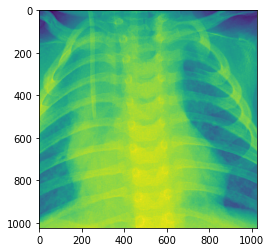

In [ ]:
print(training_data[2000])

import matplotlib.pyplot as plt

sample, label = training_data[2000]
plt.imshow(sample.numpy().reshape(1024, 1024))
print(label)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=64, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import random

class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 12, 5, stride=2)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(12, 16, 5, stride=2)
    self.conv3 = nn.Conv2d(16, 16, 5, stride=2)
    self.norm = transforms.Normalize(0.0, 1.0, True)
    # self.fc1 = nn.Linear(32 * 14 * 14, 1024)
    self.fc1 = nn.Linear(3600, 1024)
    self.fc2 = nn.Linear(1024, 128)
    self.fc3 = nn.Linear(128, 2)

    # add normalization??

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
  def nb_forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.norm(x)
    # add normalization here and maybe to the model??
    return x
  
  def print_shape(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = torch.flatten(x, 1)
    print(x.shape)

cnn = ConvNet().cuda()
x = next(iter(train_dataloader))[0].cuda()
cnn.print_shape(x)

torch.Size([64, 3600])


In [ ]:
lossfunc = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.0003)
from tqdm import tqdm

for epoch in range(2):

  running_loss = 0.0
  for i, data in tqdm(enumerate(train_dataloader, 0)):
    inputs, labels = data
    inputs = inputs.cuda()
    labels = labels.cuda()

    optimizer.zero_grad()

    outputs = cnn.forward(inputs)
    loss = lossfunc(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 10 == 9:
      print('[%d, %5d] loss: %.10f' %
                  (epoch + 1, i + 1, running_loss))
      running_loss = 0.0

      test_inputs, test_labels = iter(test_dataloader).next()
      test_inputs = test_inputs.cuda()
      pred = torch.argmax(cnn.forward(test_inputs), dim=1).cpu()
      print("Testing loss: " + str(float(torch.sum(pred == test_labels) / 64.0)))
      #print(test_labels)
      #print(pred)

print("Finished training!")

9it [00:18,  1.98s/it]

[1,    10] loss: 5.9623151124


10it [00:21,  2.45s/it]

Testing loss: 0.640625


19it [00:39,  2.00s/it]

[1,    20] loss: 5.5764411092


20it [00:43,  2.52s/it]

Testing loss: 0.5625


29it [01:01,  2.07s/it]

[1,    30] loss: 5.6162595749


30it [01:05,  2.53s/it]

Testing loss: 0.65625


39it [01:22,  2.00s/it]

[1,    40] loss: 5.4119599164


40it [01:26,  2.49s/it]

Testing loss: 0.671875


49it [01:44,  2.05s/it]

[1,    50] loss: 4.7379402518


50it [01:48,  2.64s/it]

Testing loss: 0.765625


59it [02:05,  1.94s/it]

[1,    60] loss: 3.4482610226


60it [02:08,  2.44s/it]

Testing loss: 0.84375


69it [02:26,  1.97s/it]

[1,    70] loss: 2.3076744676


70it [02:30,  2.51s/it]

Testing loss: 0.78125


79it [02:48,  2.04s/it]

[1,    80] loss: 2.2077585384


80it [02:51,  2.46s/it]

Testing loss: 0.828125


82it [02:55,  2.13s/it]
9it [00:17,  1.93s/it]

[2,    10] loss: 1.9015349299


10it [00:21,  2.54s/it]

Testing loss: 0.875


19it [00:39,  2.00s/it]

[2,    20] loss: 1.6258831620


20it [00:42,  2.48s/it]

Testing loss: 0.8125


29it [01:00,  1.97s/it]

[2,    30] loss: 1.8284537494


30it [01:04,  2.48s/it]

Testing loss: 0.796875


39it [01:21,  1.95s/it]

[2,    40] loss: 1.7892112508


40it [01:25,  2.42s/it]

Testing loss: 0.796875


49it [01:43,  2.05s/it]

[2,    50] loss: 1.6518117413


50it [01:46,  2.49s/it]

Testing loss: 0.78125


59it [02:05,  2.06s/it]

[2,    60] loss: 1.8759064227


60it [02:08,  2.58s/it]

Testing loss: 0.75


69it [02:26,  1.99s/it]

[2,    70] loss: 1.1844038218


70it [02:30,  2.46s/it]

Testing loss: 0.796875


79it [02:47,  1.95s/it]

[2,    80] loss: 1.4510249048


80it [02:51,  2.51s/it]

Testing loss: 0.78125


82it [02:54,  2.13s/it]

Finished training!


In [ ]:
num_correct = 0
num_total = 0
for i, data in tqdm(enumerate(test_dataloader, 0)):
    inputs, labels = data
    inputs = inputs.cuda()

    optimizer.zero_grad()

    pred = torch.argmax(cnn.forward(inputs), dim=1).cpu()
    num_correct += float(torch.sum(pred == labels))
    num_total += 64

print(num_correct)
print(num_total)
print(num_correct / num_total)

10it [00:16,  1.60s/it]

478.0
640
0.746875


In [ ]:
print(len(validation_data))
val_dataloader = DataLoader(validation_data, batch_size=16)

x, label = iter(val_dataloader).next()
pred = torch.argmax(cnn.forward(x.cuda()), dim=1).cpu().numpy()
label = label.numpy()
print(np.sum(pred == label) / 16.0)
print(pred)
print(label)

16
0.75
[0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


In [ ]:
!nvidia-smi

Sat Nov 27 17:52:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tqdm

In [ ]:
from tqdm import tqdm

class NaiveBayes:
    def __init__(self, dataset, num_buckets, image_size = (1024, 1024), cnn_outputs_dataset = False):
        self.dataset = dataset
        self.num_buckets = num_buckets
        self.image_size = image_size

        self.log_pneumonia_probabilities = np.zeros((image_size[0], image_size[1], num_buckets - 1))
        self.log_normal_probabilities = np.zeros((image_size[0], image_size[1], num_buckets - 1))

        self.normal_prior = 0
        self.pneumonia_prior = 0

        self.pixel_intensity_buckets = np.linspace(0, 1, num=num_buckets)

        if(cnn_outputs_dataset): self.train_from_cnn()
        else: self.train()
    
    def train(self):
        image = None
        label = None

        for i in tqdm(range(len(self.dataset))):
            image, label = self.dataset[i]
            image = image.numpy().reshape(self.image_size[0], self.image_size[1])

            if (label == 1):
              self.pneumonia_prior += 1
            else:
              self.normal_prior += 1

            for j in range(1, self.num_buckets):
                lower_bound = self.pixel_intensity_buckets[j - 1]
                upper_bound = self.pixel_intensity_buckets[j]

                if (np.argwhere(np.logical_and(image < upper_bound, image > lower_bound)).size != 0):
                    if (label == 1):
                        self.log_pneumonia_probabilities[np.logical_and(image < upper_bound, image > lower_bound), (j - 1)] += 1
                    else:
                        self.log_normal_probabilities[np.logical_and(image < upper_bound, image > lower_bound), (j - 1)] += 1
        
        self.log_normal_probabilities += 1
        self.log_pneumonia_probabilities += 1

        self.log_pneumonia_probabilities /= self.dataset.num_pneumonia
        self.log_normal_probabilities /= self.dataset.num_normal

        self.log_normal_probabilities = np.log(self.log_normal_probabilities)
        self.log_pneumonia_probabilities = np.log(self.log_pneumonia_probabilities)

        self.pneumonia_prior /= self.dataset.length
        self.normal_prior /= self.dataset.length

        self.normal_prior = np.log(self.normal_prior)
        self.pneumonia_prior = np.log(self.pneumonia_prior)

    def predict(self, image):
        image = image.numpy().reshape(self.image_size[0], self.image_size[1])
        prob_pneumonia, prob_normal = 0, 0

        for i in range(1, self.num_buckets):
            lower_bound = self.pixel_intensity_buckets[i - 1]
            upper_bound = self.pixel_intensity_buckets[i]

            if (np.argwhere(np.logical_and(image < upper_bound, image > lower_bound)).size != 0):
                prob_pneumonia += self.pneumonia_prior + np.sum(self.log_pneumonia_probabilities[np.logical_and(image < upper_bound, image > lower_bound), (i - 1)])
                prob_normal += self.normal_prior + np.sum(self.log_normal_probabilities[np.logical_and(image < upper_bound, image > lower_bound), (i - 1)])
        
        return 1 if prob_pneumonia > prob_normal else 0
    
    def Eval(self, eval_dataset):
        num_correct = 0
        num_avail = eval_dataset.length

        for i in tqdm(range(len(eval_dataset))):
            image, label = eval_dataset[i]
            predicted_label = self.predict(image)

            if (label == predicted_label): num_correct += 1

        return num_correct / num_avail
    
    def train_from_cnn(self):
        image = None
        label = None

        for i in tqdm(range(len(self.dataset))):
            image, label = self.dataset[i]
            image = image.numpy().reshape(self.image_size[0], self.image_size[1])

            if (label == 1):
              self.pneumonia_prior += 1
            else:
              self.normal_prior += 1

            for j in range(1, self.num_buckets):
                lower_bound = self.pixel_intensity_buckets[j - 1]
                upper_bound = self.pixel_intensity_buckets[j]

                if (np.argwhere(np.logical_and(image < upper_bound, image > lower_bound)).size != 0):
                    if (label == 1):
                        self.log_pneumonia_probabilities[np.logical_and(image < upper_bound, image > lower_bound), (j - 1)] += 1
                    else:
                        self.log_normal_probabilities[np.logical_and(image < upper_bound, image > lower_bound), (j - 1)] += 1
        
        self.log_normal_probabilities += 1
        self.log_pneumonia_probabilities += 1

        data_len = self.pneumonia_prior + self.normal_prior

        self.log_pneumonia_probabilities /= data_len
        self.log_normal_probabilities /= data_len

        self.log_normal_probabilities = np.log(self.log_normal_probabilities)
        self.log_pneumonia_probabilities = np.log(self.log_pneumonia_probabilities)

        self.pneumonia_prior /= data_len
        self.normal_prior /= data_len

        self.normal_prior = np.log(self.normal_prior)
        self.pneumonia_prior = np.log(self.pneumonia_prior)

    def Eval_CNN(self, eval_cnn_input):
        num_correct = 0
        num_avail = len(eval_cnn_input)

        for i in tqdm(range(len(eval_cnn_input))):
            image, label = eval_cnn_input[i]
            predicted_label = self.predict(image)

            if (label == predicted_label): num_correct += 1

        return num_correct / num_avail

In [ ]:
print(f'Length of training dataset: {training_data.length}, Length of test dataset: {testing_data.length}')
nb = NaiveBayes(training_data, 20)

Length of training dataset: 5216, Length of test dataset: 624


100%|██████████| 5216/5216 [24:50<00:00,  3.50it/s]


In [ ]:
print(f'Accuracy on testing set: {nb.Eval(testing_data)}')

100%|██████████| 624/624 [02:51<00:00,  3.64it/s]

Accuracy on testing set: 0.7996794871794872


In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import optim
import random

class SVM(nn.Module):
    def __init__(self):
      super(SVM, self).__init__()

      self.conv1 = nn.Conv2d(1, 32, (3,3), padding='same')
      self.pool = nn.MaxPool2d(8, stride=8)
      self.conv2 = nn.Conv2d(32, 32, (3,3), padding='same')

      self.linear1 = nn.Linear(8192, 128)
      self.relu_act = nn.ReLU()
      self.linear2 = nn.Linear(128, 1)

    def forward(self, X):
      x_conv1 = self.conv1(X)
      x_pool1 = self.pool(x_conv1)
      x_conv2 = self.conv2(x_pool1)
      x_pool2 = self.pool(x_conv2)

      x_flatten = torch.flatten(x_pool2)
      x_linear1_relu_act = self.relu_act(self.linear1(x_flatten))
      out = self.linear2(x_linear1_relu_act)

      return out

def EvalNet(data, net):
  num_correct = 0
  num_avail = data.length

  for i in tqdm(range(len(data))):
      image, label = data[i]
      image = image.reshape(1, 1, 1024, 1024)

      predicted_label = net.forward(image.cuda())

      if (label == 0 and predicted_label.item() < 0): num_correct += 1
      elif (label == 1 and predicted_label.item() > 0): num_correct += 1

  print("Accuracy: %s" % (float(num_correct) / float(num_avail)))

def Train(net, data, dev):
  print("Start Training!")

  optimizer = optim.Adam(net.parameters(), weight_decay=0.01) # weight decay for l2 regularization

  for epoch in range(10):
    num_correct = 0
    total_loss = 0.0
    net.train()   #Put the network into training mode

    index_values = list(range(0, len(data)))
    random.shuffle(index_values)

    for i in tqdm(index_values):
      image, label = data[i]
      image = image.reshape(1, 1, 1024, 1024)

      net.zero_grad()
      w_x = net.forward(image.cuda())

      label = (label * 2) - 1
      
      loss = 1 - w_x * label
      if loss.item() > 0: # hinge loss
        total_loss += loss

        loss.backward()
        optimizer.step()

    net.eval()    #Switch to eval mode
    print(f"loss on epoch {epoch} = {total_loss}")
    EvalNet(dev, net)

In [ ]:
svm = SVM().cuda()
Train(svm, training_data, testing_data)

Start Training!


100%|██████████| 5216/5216 [03:20<00:00, 26.01it/s]


loss on epoch 0 = tensor([840.5950], device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 624/624 [00:22<00:00, 27.32it/s]


Accuracy: 0.7451923076923077


100%|██████████| 5216/5216 [03:27<00:00, 25.19it/s]


loss on epoch 1 = tensor([469.4520], device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 624/624 [00:22<00:00, 27.64it/s]


Accuracy: 0.7564102564102564


100%|██████████| 5216/5216 [03:24<00:00, 25.47it/s]


loss on epoch 2 = tensor([338.4084], device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 624/624 [00:22<00:00, 27.88it/s]


Accuracy: 0.7676282051282052


100%|██████████| 5216/5216 [03:23<00:00, 25.61it/s]


loss on epoch 3 = tensor([262.0158], device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 624/624 [00:22<00:00, 27.74it/s]


Accuracy: 0.8012820512820513


100%|██████████| 5216/5216 [03:22<00:00, 25.71it/s]


loss on epoch 4 = tensor([225.4829], device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 624/624 [00:22<00:00, 27.69it/s]


Accuracy: 0.7740384615384616


100%|██████████| 5216/5216 [03:21<00:00, 25.87it/s]


loss on epoch 5 = tensor([174.8675], device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 624/624 [00:22<00:00, 28.26it/s]


Accuracy: 0.7339743589743589


100%|██████████| 5216/5216 [03:20<00:00, 25.96it/s]


loss on epoch 6 = tensor([168.7833], device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 624/624 [00:21<00:00, 28.46it/s]


Accuracy: 0.7868589743589743


100%|██████████| 5216/5216 [03:20<00:00, 25.97it/s]


loss on epoch 7 = tensor([135.9084], device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 624/624 [00:22<00:00, 28.16it/s]


Accuracy: 0.7355769230769231


100%|██████████| 5216/5216 [03:24<00:00, 25.55it/s]


loss on epoch 8 = tensor([137.1388], device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 624/624 [00:22<00:00, 27.59it/s]


Accuracy: 0.8060897435897436


100%|██████████| 5216/5216 [03:23<00:00, 25.60it/s]


loss on epoch 9 = tensor([87.6881], device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 624/624 [00:22<00:00, 27.95it/s]

Accuracy: 0.7403846153846154


In [ ]:
import gc

def generate_nb_cnn_input(cnn, dataloader):
  gc.collect()
  torch.cuda.empty_cache()

  nb_input = []
  cnn_encoded_train = []
  train_labels = []
  cnn.eval() 

  for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs = inputs.cuda()
      train_labels.append(labels)
      with torch.no_grad(): output = cnn.nb_forward(inputs).cpu()
      cnn_encoded_train.append(output)

      torch.cuda.empty_cache()
      gc.collect()

  labels = torch.cat(train_labels)
  output = torch.cat(cnn_encoded_train)

  for i in range(labels.shape[0]):
    for j in range(output.shape[1]):
      nb_input.append((output[i][j], labels[i]))

  return nb_input

nb_input = generate_nb_cnn_input(cnn, train_dataloader)
nb_input_test = generate_nb_cnn_input(cnn, test_dataloader)

In [ ]:
nb_cnn = NaiveBayes(nb_input, 75, image_size = (15, 15), cnn_outputs_dataset = True)

100%|██████████| 83456/83456 [04:27<00:00, 312.28it/s]


In [ ]:
print(f'Accuracy on testing set: {nb_cnn.Eval_CNN(nb_input_test)}')

100%|██████████| 9984/9984 [00:37<00:00, 262.95it/s]

Accuracy on testing set: 0.5763221153846154
